In [1]:
# N-Dimensional Toy training example

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# graph viz tool
# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
torch.manual_seed(6664)
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# Define 2d Toy Data
def def_data(centers, sep_plane, sep_plane_bias):

    # gaussian target parameters
    sigma = 0.33

    num_samples = 125

    samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=2)+centers for _ in range(num_samples)] )

    # apply labels based on side of sep hyper plane
    samples_labels = np.array([ [1] if (x)>sep_plane_bias else [-1] for x in np.matmul(samples_xs, sep_plane)])
    
    return samples_xs, samples_labels

In [7]:
centers = [-1,0]
sep_plane = [-1,0]
sep_plane_bias = 1
samples_xs1, samples_labels1 = def_data(centers, sep_plane, sep_plane_bias)

centers = [1,0]
sep_plane = [1,0]
sep_plane_bias = 1
samples_xs2, samples_labels2 = def_data(centers, sep_plane, sep_plane_bias)

centers = [0,-1]
sep_plane = [0,-1]
sep_plane_bias = 1
samples_xs3, samples_labels3 = def_data(centers, sep_plane, sep_plane_bias)

centers = [0,1]
sep_plane = [0,1]
sep_plane_bias = 1
samples_xs4, samples_labels4 = def_data(centers, sep_plane, sep_plane_bias)

samples_xs = np.concatenate((samples_xs1,samples_xs2,samples_xs3,samples_xs4))
samples_labels = np.concatenate((samples_labels1,samples_labels2,samples_labels3,samples_labels4))

<IPython.core.display.Javascript object>


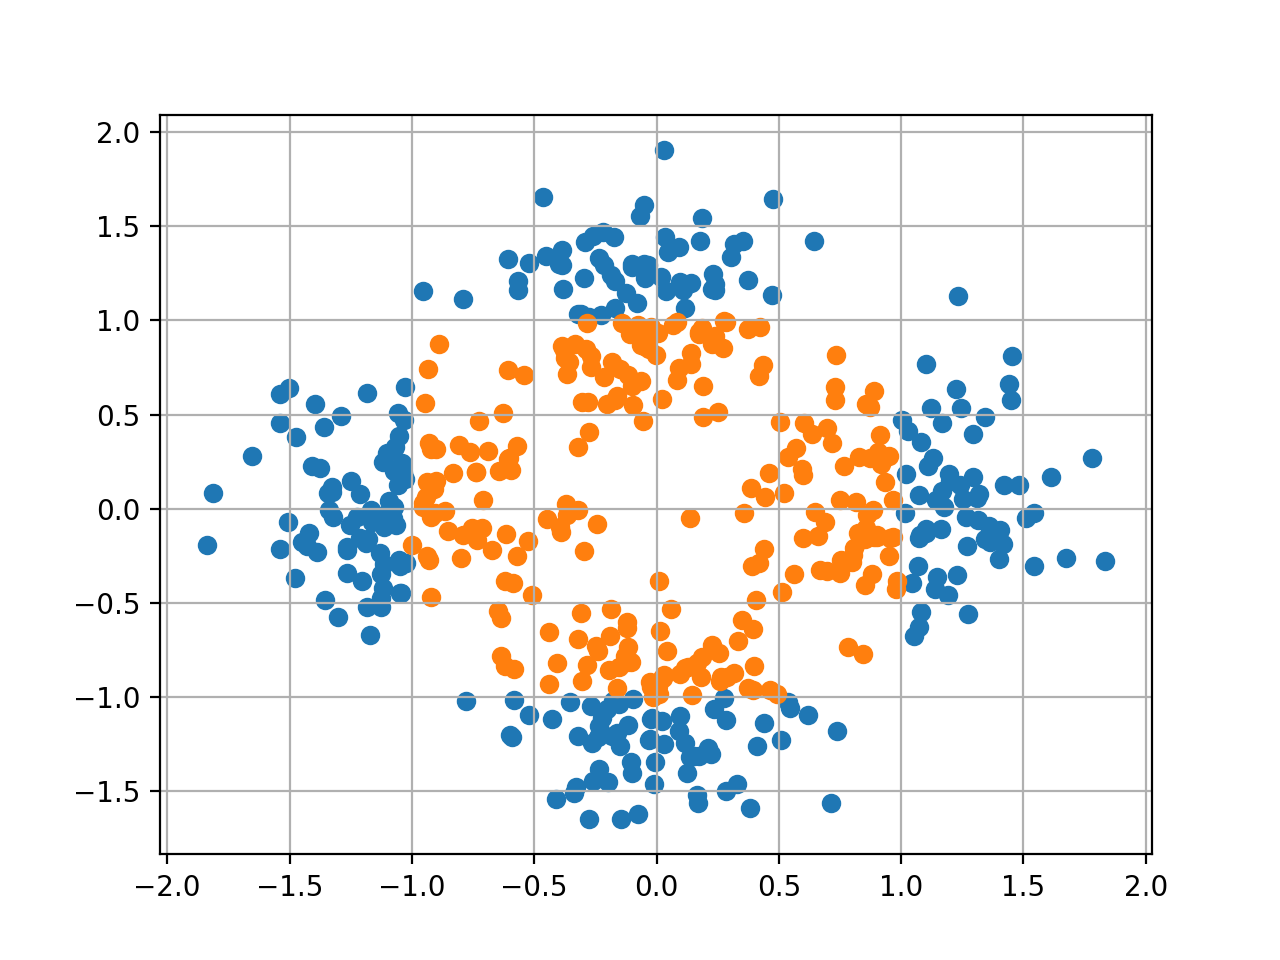

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
num_samples = samples_labels.size

# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=256) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# define the FGN layer class

###
# HARDCODED to be off center but not too far
### 

import math 

class FGN_layer(nn.Module):
    r""" Applies a Finite Gaussian Neuron layer to the incoming data
    
    Args:
    
    Shape:
    
    Attributes:
    
    Examples:
        
        >>> l=FGN_layer(20,30)
    
    """
    def __init__(self, in_features, out_features):
        super(FGN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # learnable parameters
        # regular NN weights (transposed at the start, see order of Tensor(dims))
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad= True)
        # centers of FGNs
        self.centers = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad = True)
        # size of FGNs
        self.sigs = nn.Parameter(torch.Tensor(out_features,), requires_grad = True)
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        s = np.sqrt(self.in_features)
        # regular NN init
        self.weights.data.uniform_(-s, s)
        # centers init
        self.centers.data.uniform_(-1, 1)
        # size init
        self.sigs.data.uniform_(self.in_features, self.in_features)
        
    def forward(self, input):
        
        # linear part is the same as normal NNs
        l = nn.functional.linear(input, self.weights, bias=None)
        # optional, apply tanh here
        # l = torch.tanh(l)
#         print("size of L", l.size())
#         print(l)


        # gaussian component
        # unsqueeze the inputs to allow broadcasting
        # compute distance to centers
        g = (input.unsqueeze(1)-self.centers)**2
#         print("size of G", g.size())
#         print(g)
        g = g.sum(dim=2)
#         print("size of G", g.size())

        # for future, use any norm?
#         g = torch.norm(input.unsqueeze(1)-self.centers, p=1, dim=2)

        # apply sigma
        g = -g/(self.sigs**2)
#         print("size of G", g.size())
        # apply exponential
        g = torch.exp(g)
#         print("size of G", g.size())

        # combine gaussian with linear
        res = l*g
        # optional, flatten res
        # res = F.tanh(res)
#         print("size of L*G", res.size())

        # clip res to +1
        res  = torch.clamp(res, min=-1.0, max=1.0)
        
        return res

In [11]:
# Define a (very specific) Finite Gaussian Neural Network

num_dim = samples_xs.shape[-1]

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = FGN_layer(num_dim,4)

    def forward(self, x):
        # input: tensor of batch (batchsize, (num_dims,))
#         print(x.shape)
        x = self.l1(x)
        x = x.sum(dim=-1)
#         x = torch.clamp(x, min=-1.0, max=1.0)
#         print(x.shape) 

        return x

In [12]:
# Initialize the network
model = FGNet().to(device)

In [13]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())

# check weights before training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])

FGNet(
  (l1): FGN_layer()
)
[torch.Size([4, 2]), torch.Size([4, 2]), torch.Size([4])]
Training? True
l1
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4])
l1
[-1.2045286  -1.3824832   1.2235638   0.72585094]
[ 0.00130093 -0.4003973  -0.44839275  0.9870579 ]
[2. 2. 2. 2.]


In [14]:
def train(model, device, train_loader, optimizer, epoch):
    
    # values to return
    weights =  []
    centers = []
    sigmas = []
    weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
    centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
    sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
    
    losses = th.AverageMeter()
    correct = 0
    
    # set model to trainable mode
    model.train()
    # load a batch
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(data,target)
        # load batch data, targets to device
        data, target = data.to(device), target.to(device)
        # reset optimizer gradients
        optimizer.zero_grad()
        # compute predictions
        output = model(data)
#         print(output)
        # compute loss
#         print(output.size(), target.size())
        loss = F.mse_loss(output, target.float())
        # print(loss)
        
        # update rolling average loss
        losses.update(loss.item(), data.size(0) )
        # update predictions
        pred = torch.Tensor.sign(output)
        correct += pred.eq(target.view_as(pred)).sum().item()        
        
        # propagate gradients
        loss.backward()
#         print("max grad centers:", torch.max(model.l1.centers.grad) )
#         print("max grad sigs:", torch.max(model.l1.sigs.grad) )

        # apply stored gradients to parameters
        optimizer.step()
        
        # print batch stats
#         if batch_idx % (num_samples/5) == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             print("batch:", batch_idx, " Loss", losses.avg)
    
        weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
        centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
        sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
        
        
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        losses.avg, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

    return(weights, centers, sigmas)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target.float())
            pred = torch.Tensor.sign(output)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [15]:
# training params 
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, weight_decay=0.0001)

# values to observes
weights_per_update =  []
centers_per_update = []
sigmas_per_update = []

In [26]:
# train the model 


for epoch in range(1, 10000):
    print("Epoch:", epoch)
    weights, centers, sigmas = train(model, device, my_dataloader, optimizer, epoch)
    weights_per_update+=weights
    centers_per_update+=centers
    sigmas_per_update+=sigmas
    
    test(model, device, my_test_dataloader)

Epoch: 1
Train set: Average loss: 0.9975, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 2
Train set: Average loss: 0.9975, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 3
Train set: Average loss: 0.9975, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 4
Train set: Average loss: 0.9975, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 5
Train set: Average loss: 0.9975, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 6
Train set: Average loss: 0.9975, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 7
Train set: Average loss: 0.9975, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 8
Train set: Average loss: 0.9975, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 38/100 (38%)
Epoch: 9
Train set: Average loss

Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 72
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 73
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 74
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 75
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 76
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 77
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 78
Train set: Average loss: 0.9974, Accuracy: 207/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 79
Train set: Average loss:

Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 143
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 144
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 145
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 146
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 147
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 148
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 149
Train set: Average loss: 0.9973, Accuracy: 208/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 150
Train set: Avera

Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 215
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 216
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9826, Accuracy: 39/100 (39%)
Epoch: 217
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 218
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 219
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 220
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 221
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Average loss: 0.9825, Accuracy: 39/100 (39%)
Epoch: 222
Train set: Average loss: 0.9972, Accuracy: 209/400 (52%)
Test set: Averag

Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 284
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 285
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 286
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 287
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 288
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 289
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 290
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 39/100 (39%)
Epoch: 291
Train set: Average loss: 0.9972, Accuracy: 212/400 (53%)
Test set: Averag

Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 355
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 356
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 357
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 358
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 359
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 360
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 361
Train set: Average loss: 0.9971, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9821, Accuracy: 39/100 (39%)
Epoch: 362
Train set: Avera

Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 427
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 428
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 429
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 430
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 431
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 432
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 433
Train set: Average loss: 0.9970, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9820, Accuracy: 39/100 (39%)
Epoch: 434
Train set: Avera

Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 496
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 497
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 498
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 499
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 500
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 501
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 502
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9819, Accuracy: 39/100 (39%)
Epoch: 503
Train set: Average loss: 0.9970, Accuracy: 215/400 (54%)
Test set: Averag

Test set: Average loss: 0.9817, Accuracy: 40/100 (40%)
Epoch: 564
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9817, Accuracy: 40/100 (40%)
Epoch: 565
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9817, Accuracy: 40/100 (40%)
Epoch: 566
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9816, Accuracy: 40/100 (40%)
Epoch: 567
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9816, Accuracy: 40/100 (40%)
Epoch: 568
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9816, Accuracy: 40/100 (40%)
Epoch: 569
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9816, Accuracy: 40/100 (40%)
Epoch: 570
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9816, Accuracy: 40/100 (40%)
Epoch: 571
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Averag

Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 632
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 633
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 634
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 635
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 636
Train set: Average loss: 0.9969, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 637
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 638
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9814, Accuracy: 40/100 (40%)
Epoch: 639
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Averag

Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 705
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 706
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 707
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 708
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 709
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 710
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 711
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9810, Accuracy: 41/100 (41%)
Epoch: 712
Train set: Average loss: 0.9968, Accuracy: 215/400 (54%)
Test set: Averag

Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 41/100 (41%)
Epoch: 776
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 41/100 (41%)
Epoch: 777
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 41/100 (41%)
Epoch: 778
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 42/100 (42%)
Epoch: 779
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 42/100 (42%)
Epoch: 780
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 42/100 (42%)
Epoch: 781
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9807, Accuracy: 42/100 (42%)
Epoch: 782
Train set: Average loss: 0.9968, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9806, Accuracy: 42/100 (42%)
Epoch: 783
Train set: Avera

Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 844
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 845
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 846
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 847
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 848
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 849
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 850
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9803, Accuracy: 41/100 (41%)
Epoch: 851
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Averag

Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 917
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 918
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 919
Train set: Average loss: 0.9967, Accuracy: 216/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 920
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 921
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 922
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 923
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9799, Accuracy: 41/100 (41%)
Epoch: 924
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Averag

Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9797, Accuracy: 41/100 (41%)
Epoch: 988
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9797, Accuracy: 41/100 (41%)
Epoch: 989
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9797, Accuracy: 41/100 (41%)
Epoch: 990
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9796, Accuracy: 41/100 (41%)
Epoch: 991
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9796, Accuracy: 41/100 (41%)
Epoch: 992
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9796, Accuracy: 41/100 (41%)
Epoch: 993
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9796, Accuracy: 41/100 (41%)
Epoch: 994
Train set: Average loss: 0.9967, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9796, Accuracy: 41/100 (41%)
Epoch: 995
Train set: Avera

Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1056
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1057
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1058
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1059
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1060
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1061
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1062
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1063
Train se

Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1124
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1125
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1126
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1127
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1128
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1129
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1130
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1131
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set

Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1191
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1192
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1193
Train set: Average loss: 0.9966, Accuracy: 215/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1194
Train set: Average loss: 0.9966, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1195
Train set: Average loss: 0.9966, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1196
Train set: Average loss: 0.9966, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1197
Train set: Average loss: 0.9966, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1198
Train set: Average loss: 0.9966, Accuracy: 214/400 (54%)
Test set

Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1263
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1264
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1265
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1266
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1267
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1268
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1269
Train set: Average loss: 0.9966, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1270
Train se

Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1332
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1333
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1334
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1335
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1336
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1337
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1338
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9794, Accuracy: 41/100 (41%)
Epoch: 1339
Train se

Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1400
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 41/100 (41%)
Epoch: 1401
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1402
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1403
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1404
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1405
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1406
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9795, Accuracy: 40/100 (40%)
Epoch: 1407
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1470
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1471
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1472
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1473
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1474
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1475
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9796, Accuracy: 40/100 (40%)
Epoch: 1476
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9797, Accuracy: 40/100 (40%)
Epoch: 1477
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set

Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1543
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1544
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1545
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1546
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1547
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1548
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1549
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9799, Accuracy: 42/100 (42%)
Epoch: 1550
Train se

Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1612
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1613
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1614
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1615
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1616
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1617
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1618
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9802, Accuracy: 43/100 (43%)
Epoch: 1619
Train set: Average loss: 0.9965, Accuracy: 212/400 (53%)
Test set

Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1680
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1681
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1682
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1683
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1684
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1685
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9804, Accuracy: 43/100 (43%)
Epoch: 1686
Train set: Average loss: 0.9965, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9805, Accuracy: 43/100 (43%)
Epoch: 1687
Train se

Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1748
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1749
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1750
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1751
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1752
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1753
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1754
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9807, Accuracy: 44/100 (44%)
Epoch: 1755
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1817
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1818
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1819
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1820
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1821
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1822
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1823
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9810, Accuracy: 44/100 (44%)
Epoch: 1824
Train set: Average loss: 0.9964, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1885
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1886
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1887
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1888
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1889
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1890
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1891
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9813, Accuracy: 44/100 (44%)
Epoch: 1892
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1953
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1954
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1955
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1956
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1957
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1958
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1959
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9816, Accuracy: 44/100 (44%)
Epoch: 1960
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9817, Accuracy: 44/100 (44%)
Epoch: 2022
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9817, Accuracy: 44/100 (44%)
Epoch: 2023
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9817, Accuracy: 44/100 (44%)
Epoch: 2024
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9817, Accuracy: 44/100 (44%)
Epoch: 2025
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9818, Accuracy: 44/100 (44%)
Epoch: 2026
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9818, Accuracy: 44/100 (44%)
Epoch: 2027
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9818, Accuracy: 44/100 (44%)
Epoch: 2028
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9818, Accuracy: 44/100 (44%)
Epoch: 2029
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2095
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2096
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2097
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2098
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2099
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2100
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2101
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9819, Accuracy: 45/100 (45%)
Epoch: 2102
Train se

Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2166
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2167
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2168
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2169
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2170
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2171
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2172
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9820, Accuracy: 45/100 (45%)
Epoch: 2173
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2237
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2238
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2239
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2240
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2241
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2242
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2243
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9821, Accuracy: 45/100 (45%)
Epoch: 2244
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2306
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2307
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2308
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2309
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2310
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2311
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2312
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9822, Accuracy: 45/100 (45%)
Epoch: 2313
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2378
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2379
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2380
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2381
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2382
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2383
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2384
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9823, Accuracy: 45/100 (45%)
Epoch: 2385
Train set: Average loss: 0.9964, Accuracy: 212/400 (53%)
Test set

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2446
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2447
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2448
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2449
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2450
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2451
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2452
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9824, Accuracy: 45/100 (45%)
Epoch: 2453
Train se

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2516
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2517
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2518
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2519
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2520
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2521
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2522
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9825, Accuracy: 45/100 (45%)
Epoch: 2523
Train se

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2583
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2584
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2585
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2586
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2587
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2588
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2589
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9826, Accuracy: 45/100 (45%)
Epoch: 2590
Train se

Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2653
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2654
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2655
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2656
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2657
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2658
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2659
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9827, Accuracy: 45/100 (45%)
Epoch: 2660
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2724
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2725
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2726
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2727
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2728
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2729
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2730
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9828, Accuracy: 45/100 (45%)
Epoch: 2731
Train se

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2793
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2794
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2795
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2796
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2797
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2798
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2799
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9829, Accuracy: 46/100 (46%)
Epoch: 2800
Train se

Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2861
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2862
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2863
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2864
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2865
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2866
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2867
Train set: Average loss: 0.9963, Accuracy: 211/400 (53%)
Test set: Average loss: 0.9831, Accuracy: 46/100 (46%)
Epoch: 2868
Train se

Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2927
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2928
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2929
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2930
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2931
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2932
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2933
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9832, Accuracy: 46/100 (46%)
Epoch: 2934
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 2999
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3000
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3001
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3002
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3003
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3004
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3005
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set: Average loss: 0.9834, Accuracy: 46/100 (46%)
Epoch: 3006
Train set: Average loss: 0.9963, Accuracy: 212/400 (53%)
Test set

Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3071
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3072
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3073
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3074
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3075
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3076
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3077
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9836, Accuracy: 46/100 (46%)
Epoch: 3078
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set

Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3140
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3141
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3142
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3143
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3144
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3145
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3146
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9838, Accuracy: 46/100 (46%)
Epoch: 3147
Train se

Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3212
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3213
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3214
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3215
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3216
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3217
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3218
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9840, Accuracy: 46/100 (46%)
Epoch: 3219
Train se

Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3279
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3280
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3281
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3282
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3283
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3284
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3285
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9842, Accuracy: 46/100 (46%)
Epoch: 3286
Train se

Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3348
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3349
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3350
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3351
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3352
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3353
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3354
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9844, Accuracy: 46/100 (46%)
Epoch: 3355
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set

Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3418
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3419
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3420
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3421
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3422
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3423
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3424
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9846, Accuracy: 46/100 (46%)
Epoch: 3425
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set

Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3490
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3491
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3492
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3493
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3494
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3495
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3496
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9848, Accuracy: 46/100 (46%)
Epoch: 3497
Train se

Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3559
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3560
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3561
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3562
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3563
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3564
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3565
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9850, Accuracy: 46/100 (46%)
Epoch: 3566
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set

Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3629
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3630
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3631
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3632
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3633
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3634
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3635
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9851, Accuracy: 46/100 (46%)
Epoch: 3636
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set

Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3698
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3699
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3700
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3701
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3702
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3703
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3704
Train set: Average loss: 0.9963, Accuracy: 214/400 (54%)
Test set: Average loss: 0.9853, Accuracy: 46/100 (46%)
Epoch: 3705
Train se

Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3769
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3770
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3771
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3772
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3773
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3774
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3775
Train set: Average loss: 0.9963, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 46/100 (46%)
Epoch: 3776
Train se

Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3835
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3836
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3837
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3838
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3839
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3840
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3841
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 3842
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3907
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3908
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3909
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3910
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3911
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3912
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 3913
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3914
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3974
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3975
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3976
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3977
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3978
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 3979
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 3980
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 3981
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4045
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4046
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4047
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4048
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4049
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4050
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4051
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 4052
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4112
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4113
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4114
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4115
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4116
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4117
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4118
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 4119
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4179
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4180
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4181
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4182
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4183
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4184
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4185
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 4186
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4248
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4249
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4250
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4251
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4252
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4253
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4254
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4255
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4318
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4319
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4320
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4321
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4322
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4323
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4324
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 4325
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4390
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4391
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4392
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4393
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4394
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4395
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4396
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4397
Train se

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4461
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4462
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4463
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4464
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4465
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4466
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4467
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4468
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4530
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4531
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4532
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4533
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4534
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4535
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4536
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4537
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4599
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4600
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4601
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4602
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4603
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4604
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4605
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4606
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4670
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4671
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4672
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4673
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4674
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4675
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4676
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4677
Train se

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4740
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4741
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4742
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4743
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4744
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4745
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4746
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4747
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4807
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4808
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4809
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4810
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4811
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4812
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4813
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4814
Train se

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4873
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4874
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4875
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4876
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4877
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4878
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4879
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4880
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4941
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4942
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4943
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4944
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4945
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4946
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4947
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9862, Accuracy: 45/100 (45%)
Epoch: 4948
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5010
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5011
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5012
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5013
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5014
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5015
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5016
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5017
Train se

Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5078
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5079
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5080
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5081
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5082
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5083
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5084
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9861, Accuracy: 45/100 (45%)
Epoch: 5085
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5148
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5149
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5150
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5151
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5152
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5153
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5154
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5155
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5220
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5221
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5222
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5223
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5224
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5225
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5226
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5227
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5291
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5292
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5293
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5294
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5295
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5296
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5297
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9860, Accuracy: 45/100 (45%)
Epoch: 5298
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5361
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5362
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5363
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5364
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5365
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5366
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5367
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5368
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5428
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5429
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5430
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5431
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5432
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5433
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5434
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5435
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5495
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5496
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5497
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5498
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5499
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5500
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5501
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9859, Accuracy: 45/100 (45%)
Epoch: 5502
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5568
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5569
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5570
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5571
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5572
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5573
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5574
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5575
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5636
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5637
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5638
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5639
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5640
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5641
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5642
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5643
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5708
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5709
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5710
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5711
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5712
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5713
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5714
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9858, Accuracy: 45/100 (45%)
Epoch: 5715
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5780
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5781
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5782
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5783
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5784
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5785
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5786
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5787
Train se

Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5849
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5850
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5851
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5852
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5853
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5854
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5855
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5856
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5918
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5919
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5920
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5921
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5922
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5923
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5924
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9857, Accuracy: 45/100 (45%)
Epoch: 5925
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5985
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5986
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5987
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5988
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5989
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5990
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5991
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 5992
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6056
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6057
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6058
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6059
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6060
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6061
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6062
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6063
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6127
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6128
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6129
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6130
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6131
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6132
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6133
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6134
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6196
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9856, Accuracy: 45/100 (45%)
Epoch: 6197
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6198
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6199
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6200
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6201
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6202
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6203
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6264
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6265
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6266
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6267
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6268
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6269
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6270
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6271
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6335
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6336
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6337
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6338
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6339
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6340
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6341
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6342
Train se

Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6401
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6402
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6403
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6404
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6405
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6406
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6407
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9855, Accuracy: 45/100 (45%)
Epoch: 6408
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6472
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6473
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6474
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6475
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6476
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6477
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6478
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6479
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6542
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6543
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6544
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6545
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6546
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6547
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6548
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6549
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6614
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6615
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6616
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6617
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6618
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6619
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6620
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6621
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6686
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6687
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6688
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6689
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6690
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6691
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6692
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9854, Accuracy: 45/100 (45%)
Epoch: 6693
Train se

Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6757
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6758
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6759
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6760
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6761
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6762
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6763
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6764
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6829
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6830
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6831
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6832
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6833
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6834
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6835
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6836
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6897
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6898
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6899
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6900
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6901
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6902
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6903
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6904
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6965
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6966
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6967
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6968
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6969
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6970
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6971
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 6972
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7036
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7037
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7038
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7039
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7040
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7041
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7042
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9853, Accuracy: 45/100 (45%)
Epoch: 7043
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7105
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7106
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7107
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7108
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7109
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7110
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7111
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7112
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7173
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7174
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7175
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7176
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7177
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7178
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7179
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7180
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7242
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7243
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7244
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7245
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7246
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7247
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7248
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7249
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7309
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7310
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7311
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7312
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7313
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7314
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7315
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7316
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7378
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7379
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7380
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7381
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7382
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7383
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7384
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7385
Train se

Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7444
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7445
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7446
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7447
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9852, Accuracy: 45/100 (45%)
Epoch: 7448
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7449
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7450
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7451
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7513
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7514
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7515
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7516
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7517
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7518
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7519
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7520
Train se

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7584
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7585
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7586
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7587
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7588
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7589
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7590
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7591
Train se

Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7654
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7655
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7656
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7657
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7658
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7659
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7660
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7661
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7721
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7722
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7723
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7724
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7725
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7726
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7727
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7728
Train se

Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7792
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7793
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7794
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7795
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7796
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7797
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7798
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9851, Accuracy: 45/100 (45%)
Epoch: 7799
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7862
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7863
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7864
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7865
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7866
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7867
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7868
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7869
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7934
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7935
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7936
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7937
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7938
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7939
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7940
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 7941
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8001
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8002
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8003
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8004
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8005
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8006
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8007
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8008
Train se

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8071
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8072
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8073
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8074
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8075
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8076
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8077
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8078
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8142
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8143
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8144
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8145
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8146
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8147
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8148
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8149
Train se

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8213
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8214
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8215
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8216
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8217
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8218
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8219
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8220
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8282
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8283
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8284
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8285
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8286
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8287
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8288
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8289
Train se

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8349
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8350
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8351
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8352
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8353
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8354
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8355
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8356
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8417
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8418
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8419
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8420
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9850, Accuracy: 45/100 (45%)
Epoch: 8421
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8422
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8423
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8424
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8490
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8491
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8492
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8493
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8494
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8495
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8496
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8497
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8560
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8561
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8562
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8563
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8564
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8565
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8566
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8567
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8628
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8629
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8630
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8631
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8632
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8633
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8634
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8635
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8698
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8699
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8700
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8701
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8702
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8703
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8704
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8705
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8766
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8767
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8768
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8769
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8770
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8771
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8772
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8773
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8833
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8834
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8835
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8836
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8837
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8838
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8839
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8840
Train se

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8899
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8900
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8901
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8902
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8903
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8904
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8905
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8906
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8971
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8972
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8973
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8974
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8975
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8976
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8977
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 8978
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9039
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9040
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9041
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9042
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9043
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9044
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9045
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9046
Train se

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9106
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9107
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9108
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9109
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9110
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9111
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9112
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9113
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9175
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9176
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9177
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9178
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9179
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9180
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9181
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9182
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9245
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9246
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9247
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9248
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9249
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9250
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9251
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9252
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9314
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9315
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9316
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9317
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9318
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9319
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9320
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9321
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9383
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9384
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9385
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9386
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9387
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9388
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9389
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9390
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9451
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9452
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9453
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9454
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9455
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9456
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9457
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9458
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9524
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9525
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9526
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9527
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9528
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9529
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9530
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9531
Train se

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9592
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9593
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9594
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9595
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9596
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9597
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9598
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9599
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9665
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9666
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9667
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9668
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9669
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9670
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9671
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9672
Train se

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9734
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9735
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9736
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9737
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9738
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9739
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9740
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9741
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9803
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9804
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9805
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9806
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9807
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9808
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9809
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9810
Train se

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9871
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9872
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9873
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9874
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9875
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9876
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9877
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9878
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9938
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9939
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9940
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9941
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9942
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9943
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9944
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set: Average loss: 0.9849, Accuracy: 45/100 (45%)
Epoch: 9945
Train set: Average loss: 0.9962, Accuracy: 213/400 (53%)
Test set

In [27]:
# check weights after training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy())
print(model.l1.centers.view(-1).cpu().detach().numpy())
print(model.l1.sigs.view(-1).cpu().detach().numpy())

l1
[-0.9081838  -0.94235885  0.9846532   0.8594291   0.19305193 -1.0866845
 -0.27935612  1.0536475 ]
[-0.36663854  0.23107989 -0.2528261   0.30025256  0.10098183 -1.028051
 -0.13405572 -0.8427473 ]
[2.01913   2.0526857 1.9274428 2.0103855]


In [28]:
# l1
# [-0.37619257 -0.45973182 -0.7764381  -0.7976191 ]
# [ 0.43942022 -2.9525995  -1.4878825   0.31062627]
# [1.4142135 1.4142135 1.4142135 1.4142135]

<IPython.core.display.Javascript object>


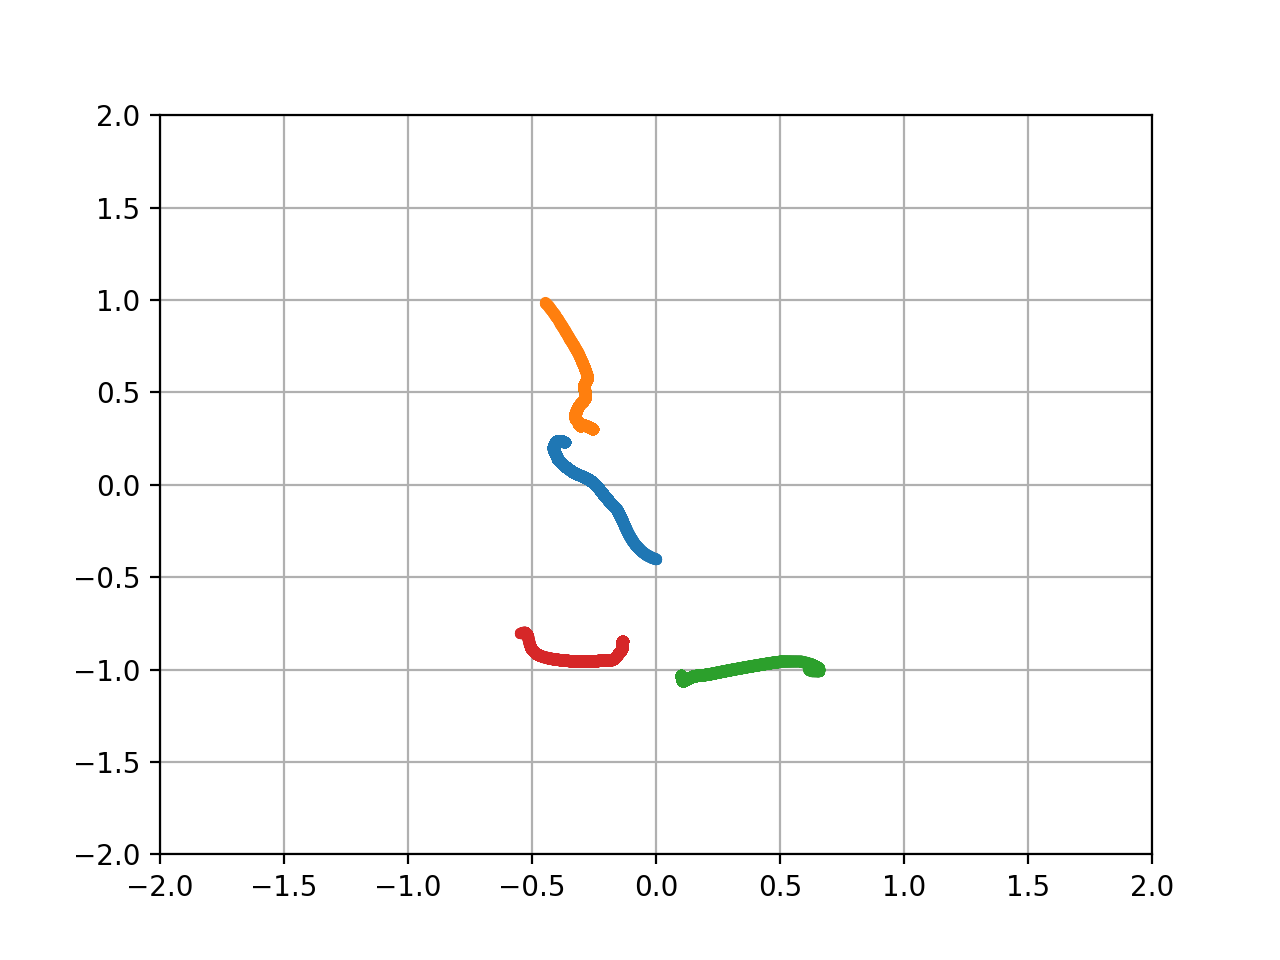

In [29]:
x1, y1, x2, y2, x3, y3, x4, y4 = zip(*centers_per_update)
plt.plot(x1,y1, marker='.', linestyle=' ')
plt.plot(x2,y2, marker='.', linestyle=' ')
plt.plot(x3,y3, marker='.', linestyle=' ')
plt.plot(x4,y4, marker='.', linestyle=' ')
plt.axis([-2,2, -2, 2])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


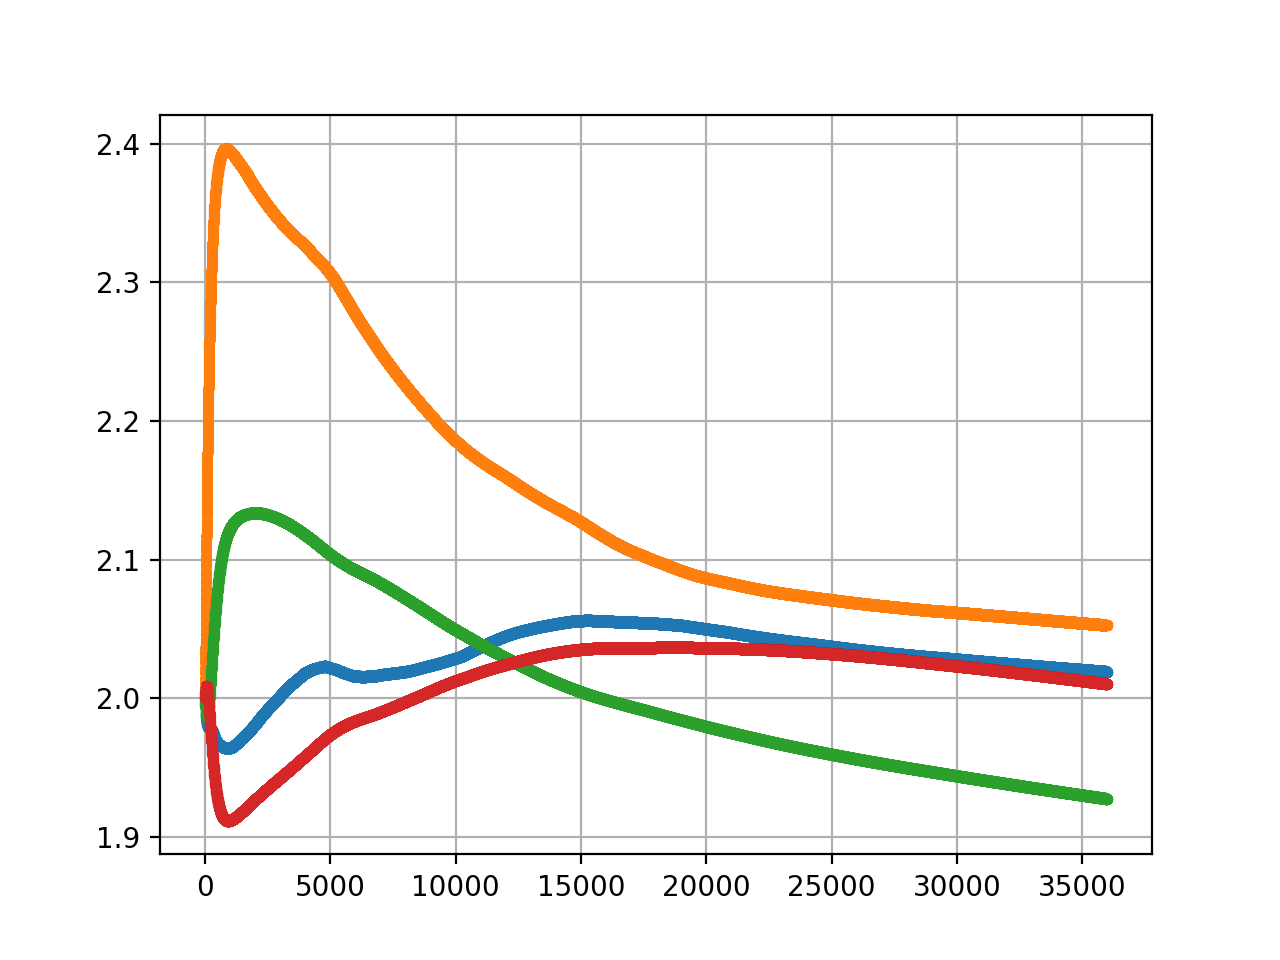

In [30]:
plt.plot(sigmas_per_update, marker='.', linestyle=' ')
plt.grid()
plt.show()